# Expectation Maximisation on Mixture Model

# Table of contents
1. [Setting the ground truth](#first-bullet)
2. [Glossary of terms](#Glossary of terms)
2a. [The model](#The model)
2b. [Probabilities](#Probabilities)
2c. [Likelihood](#Likelihood)
2d. [Intermediate values](#Intermediate values)
3. [Generating samples from ground truth](#Generating samples from ground truth)
4. [Defining the log-likelihood](#Defining log-likelihood)
5. [EM algorithm](#EM algorithm) 
5a. [Expectation Step](#Expectation Step) 
5b. [Maximisation Step](#Maximisation Step)
6. [Performing iterations](#Performing iterations) 
6a. [Setting the initial parameters](#Setting the initial parameters)

In this notebook, we are demostrating an working example of Expectation Maximisation. We will generate a set of observations from a mixture bimodal Gaussian distribution with some chosen parameters. This samples is then assumed to be observed data, and the original parameters is unknown or lost. Then, we will find the best parameters for the observation with Expectation Maximisation.

We model $\phi$ as a mixture of two Gaussian distirbutions, with parameters $\theta = (p, \mu_1, \sigma_1, \mu_2, \sigma_2)$:

$$\begin{align}
\phi &= (1 - z) \cdot \phi_1 + z\cdot \phi_2 \\
\phi_1 &\sim N(\mu_1 , \sigma_1^2 ) \\
\phi_2 &\sim N(\mu_2 , \sigma_2^2 ) 
\end{align}$$

where $z = 0 \text{ or } 1$ and $P(z = 1) = p$

Following is the pdf of $\phi$:

$$\begin{align}
\phi(x \mid \theta) &= (1 - p) \cdot \phi_1(x\mid \mu_1, \sigma_1) 
+ p \cdot \phi_2(x \mid \mu_2, \sigma_2)\\
&= \frac{1-p}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{p}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x - \mu_2)^2} {2 \sigma_2^2}}\right) 
\end{align}$$

# Glossary of terms <a class="anchor" id="Glossary of terms"></a>


### The model <a class="anchor" id="The model"></a>

$\phi$ The pdf of the bimodal Mixture Guassian distribution. The model is defined with parameter $\theta$.<BR>
$\theta$ The parameter vector of model $Y$. $\theta$ is made up of parameters $\{p, \mu_1, \sigma_1, \mu_2, \sigma_2\}$

$p$ `prob` The probability of a sample being sampled from Gaussian distribution $\phi_2$ rather than $\phi_1$.<BR>
$z$ The hidden variable that indicates which Gaussian distribution a sample was from. <BR>
If $z = 0$, then the observation was sampled from $Y_1$. <BR>
If $z = 1$, then the observation was sampled from $Y_2$.

$\phi_1$ `pdf_Y1` The first Gaussian distribution that makes up the mixture distribution. It is defined by parameters $\mu_1$ and $\sigma_1$ <BR>
$\mu_1$ `mu_1` The mean of Gaussian distribution $\phi_1$ <BR>
$\sigma_1$ `stde_1` The standard deviation of Gaussian distribution $\phi_1$

$\phi_2$ `pdf Y2` The second Gaussian distribution that makes up the mixture distribution. It is defined by of parameters $\mu_2$ and $\sigma_2$ <BR>
$\mu_2$ `mu_2` The mean of Gaussian distribution $\phi_2$ <BR>
$\sigma_2$ `stde_2` The standard deviation of Gaussian distribution $\phi_2$

$\phi$ The second Gaussian distributions that makes up the mixture distribution.

### Probabilities <a class="anchor" id="Probabilities"></a>

$\mathbf{X} = (x_1, x_2, \dots, x_N)$ `SAMPLES` The set of observations $x_i$ of length $N$ `LENGTH` sampled from ground truth.<BR>
$\mathbf{Z} = (z_1, z_2, \dots, z_N)$ The set of hidden variables of length $N$ that corresponds to the "state" $z_i$ of the system at each observation $i$.<BR>

COMMENT: WHAT IS STATE?
COMMENT: WHY BOLD X?
 
$P(x)$ Probability of event $x$ happening.<BR>
COMMENT: Are we defining it this way? How are we defining probability of obtaining a discrete variable from a continuous pdf? <BR> Shouldn't we be concerned with pdf instead?<BR>
Should we not use this and write in likelihoods?

$P(\mathbf{X} \mid  \theta)$ Conditional probability of getting observations $\mathbf{X}$ given the parameters of the model $\theta$.

$P(\mathbf{X} \mid  \mathbf{Z}, \theta)$ Conditional probability of getting observations $\mathbf{X}$ given the hidden variables $\mathbf{Z}$ and parameters of the model $\theta$

$P(\mathbf{X}, \mathbf{Z} \mid \theta)$ Conditional probability of getting both observations $\mathbf{X}$ and hidden variables $\mathbf{Z}$ given the parameters of the model $\theta$

### Likelihood <a class="anchor" id="Likelihood"></a>

$\ell(x \mid y)$ The log-likelihood of y given x. $\ell(x \mid y) = -\log P(y \mid x)$

$\ell(\theta \mid  \mathbf{X})$ `calc_log_lik` The log-likelihood of parameter $\theta$ given observations $\mathbf{X}$

$\ell(\theta \mid  \mathbf{X}, \mathbf{Z})$ The log-likelihood of parameter $\theta$ given observations $\mathbf{X}$ and hidden variables $\mathbf{Z}$. 

$\ell(\theta, \mathbf{Z} \mid \mathbf{X})$ The log-likelihood of parameter $\theta$ and hidden variables $\mathbf{Z}$ given observations $\mathbf{X}$.

### Intermediate values  <a class="anchor" id="Intermediate values"></a>


TODO: MOVE TO LATER: $\gamma$ The responsibility of one of the two Gaussians on a sample, given current model $\theta$.  "PROPORTION"

$\gamma_i$ `gamma_i` is the probability that the sample $i$ belongs to $\theta_2$ rather than $\theta_1$, given $\theta$ and $\mathbf{X}$

$\gamma_i = \mathbb{E}(z_i \,  \mid  \, \theta, \mathbf{X}) = P(z_i = 1 \,  \mid  \, \theta, x_i)$

# Setting the ground truth <a class="anchor" id="first-bullet"></a>

This is the ground truth parameter vector 
<br> $\theta_{true} = (p, \mu_1, \sigma_1, \mu_2, \sigma_2) = $ `PROB_TRUE, MEAN_1_TRUE STDE_1_TRUE, MEAN_2_TRUE, STDE_2_TRUE`  

This is used to generate the set of samples.

In [1]:
PROB_TRUE = 0.8  # probability if it lies from normal distribution 2 
MEAN_1_TRUE = 1.
STDE_1_TRUE = 1.0
MEAN_2_TRUE = 4.
STDE_2_TRUE = 0.8

We will show pdfs $\phi$ as well as $\phi_1$ and $\phi_2$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plot_range = np.arange(-5,10,0.01)
pdf_Y1 = [((1.-PROB_TRUE)/(np.sqrt(2.*np.pi*STDE_1_TRUE**2.))) * 
          np.exp(-(x - MEAN_1_TRUE)**2. / (2.*STDE_1_TRUE**2)) for x in plot_range]
pdf_Y2 = [(PROB_TRUE/(np.sqrt(2.*np.pi*STDE_2_TRUE**2.))) * 
          np.exp(-(x - MEAN_2_TRUE)**2. / (2.*STDE_2_TRUE**2)) for x in plot_range]
pdf_Y = np.add(pdf_Y1,pdf_Y2)

plt.figure(figsize=(16,4))
plt.plot(plot_range, pdf_Y1, label="Y1")
plt.plot(plot_range, pdf_Y2, label="Y2")
plt.plot(plot_range, pdf_Y, label="Y")
plt.legend(loc="best")
plt.show()

<Figure size 1600x400 with 1 Axes>

# Generating samples from the ground truth <a class="anchor" id="Generating samples from ground truth"></a>

We will now generate some samples from $\theta_{true}$. This set of samples will be  $\mathbf{X}$

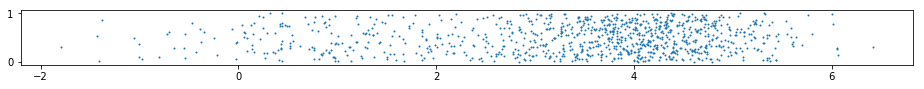

In [3]:
LENGTH = 1000
dot_size = 1.

SAMPLES = [STDE_1_TRUE*np.random.randn() + MEAN_1_TRUE
           if np.random.random() > PROB_TRUE 
           else STDE_2_TRUE*np.random.randn() + MEAN_2_TRUE
           for _ in range(LENGTH)]

plt.figure(figsize=(16,1))
plt.scatter(SAMPLES,np.random.random(LENGTH), # random to scatter points vertically
            s=dot_size)
plt.show()

We now plot the histogram of observations $\mathbf{X}$, and compare with the $\phi$.

In [4]:
def plot_hist_pdf(prob_, mean_1_, stde_1_, mean_2_, stde_2_):
    plt.figure(figsize=(16,2))
    pdf_Y1 = [((1.-prob_)/(np.sqrt(2.*np.pi*stde_1_**2.))) * 
            np.exp(-(x - mean_1_)**2. / (2.*stde_1_**2)) for x in plot_range]
    pdf_Y2 = [(prob_/(np.sqrt(2.*np.pi*stde_2_**2.))) * 
            np.exp(-(x - mean_2_)**2. / (2.*stde_2_**2)) for x in plot_range]
    pdf_Y = np.add(pdf_Y1,pdf_Y2)
    plt.hist(SAMPLES, density=True, bins=plot_range, color="orange")
    plt.plot(plot_range,pdf_Y1, label="Y1")
    plt.plot(plot_range,pdf_Y2, label="Y2")
    plt.plot(plot_range,pdf_Y, label="Y")
    plt.show()
    print("prob = {:.4f}, mean_1 = {:.4f}, mean_2 = {:.4f}, stde_1 = {:.4f}, stde_2 = {:.4f}"
      .format(prob_,mean_1_,mean_2_,stde_1_,stde_2_))

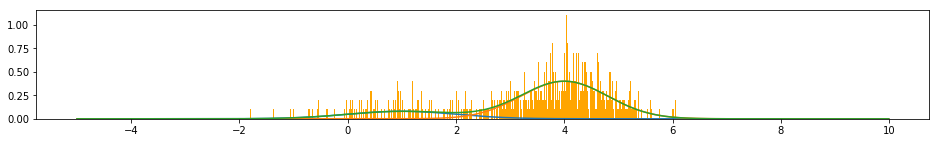

prob = 0.8000, mean_1 = 1.0000, mean_2 = 4.0000, stde_1 = 1.0000, stde_2 = 0.8000


In [5]:
plot_hist_pdf(PROB_TRUE, MEAN_1_TRUE, STDE_1_TRUE, MEAN_2_TRUE, STDE_2_TRUE)

# Defining the log-likelihood <a class="anchor" id="Defining log-likelihood"></a>

We want to maximise the likelihood w.r.t. parameter vector $\theta = \{p , \mu_1, \sigma_1, \mu_2, \sigma_2\}$ given observations $\mathbf{X}$, ie $(x_1, x_2,....., x_n)$.


$$P(\mathbf{X}  \mid  \theta) =\prod_i \left[ 
\frac{1-p}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{p}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right] $$

As product of likelihoods is too small for calculations, it is better if we maximize the log likelihood instead:

$$\begin{align}
\ell(\theta  \mid  \mathbf{X}) &= \log P(\mathbf{X}  \mid  \theta) \\
&= \sum_i log\left[ 
\frac{1-p}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right)
+ \frac{p}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right] \\
&= \sum_i log\left( 
(1-p)\phi_1 (x_i)
+ (p)\phi_2 (x_i)\right)
\end{align}$$

The evaluation of $\ell (\theta \mid \mathbf{X})$ is specified in function `calc_log_lik`

In [6]:
def calc_log_lik(prob_, mean_1_, mean_2_, stde_1_, stde_2_):
    return np.sum(
            np.log(
                (1-prob_)/(stde_1_*np.sqrt(2*np.pi))
                  *np.exp(-np.power(np.add(SAMPLES,[-mean_1_]*LENGTH),2)/(2*stde_1_**2))
                + (prob_/(stde_2_*np.sqrt(2*np.pi)))
                  *np.exp(-np.power(np.add(SAMPLES,[-mean_2_]*LENGTH),2)/(2*stde_2_**2))))

We now calculate log-likelihood w.r.t. ground truth $\theta_{true}$ `LOG_LIK_TRUE` for future reference.

In [7]:
LOG_LIK_TRUE = calc_log_lik(PROB_TRUE, MEAN_1_TRUE, MEAN_2_TRUE, STDE_1_TRUE, STDE_2_TRUE)

print("LOG_LIK_TRUE = {}".format(LOG_LIK_TRUE))

LOG_LIK_TRUE = -1657.383944268213


# EM algorithm <a class="anchor" id="EM algorithm"></a>

## General Overview
The direct maximisation of $\ell(\theta,\mathbf{X})$ is made difficult because of the sum of terms inside the logarithm. Therefore we define a function $\ell ( \theta \mid  \mathbf{X}, \mathbf{Z})$ that is equal at $\theta = \theta_0$ but lower than $\ell(\theta \mid \mathbf{X})$ everywhere else.

COMMENT: THEY ARE NOT ACTUALLY THE SAME

TODO: BORROW A PICTURE WITH REFERENCE

The interpretation of the $\mathbf{Z}$ is a vector of hidden variables taking values 0 or 1 that guesses which of distributions $\phi_1$ or $\phi_2$ each sample $x$ comes from. If $z_i = 0$ then that sample $i$ comes from $\phi_1$, if $z_i = 1$ then that sample $i$ comes from $\phi_2$.

If we are given a vector $\mathbf{Z}$ of hidden variables $( z_1, z_2, \dots, z_n )$ that are binary values of 1 or 0, the expression becomes:

$$\begin{align}
\ell(\theta, \mathbf{Z}  \mid  \mathbf{X}) &= \log P(\mathbf{X}  \mid  \theta, \mathbf{Z}) \\ 
&= \sum_i log \phi(x_i) \cdot \chi_{z_i=0} + \sum_j log \phi(x_j) \cdot \chi_{z_j=1} \\
&= \sum_i log\left( 
\frac{1- z_i}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{z_i}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right)
\end{align}$$

TODO: REMOVE Practically speaking, this then becomes the addition of the log likelihoods of exactly two different distributions, as we now are guessing exactly which distribution each sample comes from.

In [8]:
## we have an arbitrary starting point which we will elaborate later
prob, mean_1, stde_1, mean_2, stde_2 = 0.8, 2.1, 1.1, 4.1, 3.81

## Expectation Step <a class="anchor" id="Expectation Step"></a>

COMMENT: "RESPONSIBILITY"

Interpretation for responsibility $\gamma_i$: given current model $\theta$, $\gamma_i$ is the probability that the sample belongs to $\phi_2$ rather than $\phi_1$. It can also be interpreted as an approximation for $z$, as the closer $\gamma_i$ is to 1, the more likely $z$ is 1.

$$\gamma_i(\theta) = E\left(z_i  \mid  \theta, \mathbf{X}\right) = P\left(z_i = 1  \mid  \theta, \mathbf{X}\right) $$

$$ \gamma_i(\theta) = \frac{p \phi_{2} (x_i)} 
{(1 - p) \phi_{1} ( x_i ) + p \phi_{2} ( x_i )} $$

In [9]:
def expectation_step(prob,mean_1,stde_1,mean_2,stde_2):
    odds_Y1 = [((1-prob)/(stde_1*np.sqrt(2*np.pi))) 
                * np.exp(-(x - mean_1)**2. / (2. * stde_1**2)) for x in SAMPLES]
    odds_Y2 = [((prob)/(stde_2*np.sqrt(2*np.pi))) 
                * np.exp(-(x - mean_2)**2. / (2. * stde_2**2)) for x in SAMPLES]
    gamma_i = np.divide(odds_Y2,np.add(odds_Y1,odds_Y2))
    return gamma_i

gamma_i = expectation_step(prob,mean_1,stde_1,mean_2,stde_2)
print(np.round(gamma_i[:30],3))  # the gamma values of some of the samples

[ 0.781  0.537  0.638  0.972  0.952  0.547  0.856  0.878  0.876  0.851
  0.507  0.943  0.742  0.747  0.532  0.712  0.532  0.928  0.891  0.984
  0.554  0.732  0.638  0.53   0.979  0.96   0.506  0.929  0.51   0.897]


### Insertion of Hidden Variables
We first observe that we can insert the hidden variables $z$ through the law of total probability.

$$
\begin{align} 
\log P(\mathbf{X}  \mid  \theta) &= \sum_i log P(x_i \mid  \theta)   \\
&= \sum_i log\left(\sum_z P(x_i \mid z,\theta)P(z \mid \theta)\right) \\
&= \sum_i log\left( P(x_i \mid z =0,\theta)P(z=0 \mid \theta) + P(x_i \mid z =1,\theta)P(z=1 \mid \theta)\right)\\
\end{align}$$


This corresponds to
$$
\begin{align} 
\log P(\mathbf{X}  \mid  \theta) &= \sum_i log\left( \sum_z \left(
\frac{1- z}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{z}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right) \right) \cdot P(z \mid \theta)
\right) \\
&= \sum_i log\left( \left(
\frac{1- 0}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right)\cdot P(z=0) \right) \right. \\ 
&\qquad \qquad + \left. \left(\frac{1}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right) \cdot P(z=1) \right)
\right) \\ 
&= \sum_i log\left( 
\frac{(1-p)}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{(p)}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right)
\right) \\
&= \sum_i log\left( 
(1-p)\phi_1 (x_i)
+ (p)\phi_2 (x_i)\right)
\end{align}
$$

This simplification shows us that the insertion of the hidden variables stil makes the expression mathematically equal to our $\log P(\mathbf{X}  \mid  \theta)$ expression at first.

### Derivation of $log P(\mathbf{X}  \mid  \mathbf{Z}, \theta)$

The form of $log P(\mathbf{X},\mathbf{Z}  \mid  \theta)$ is required in the Expectation step. It has been derived in the EM tutorial (and will be derived later) and is needed to find the next iteration of $\theta$. Hence, we want to find the form of $log P(\mathbf{X},\mathbf{Z}  \mid  \theta)$.

$$
\begin{align} 
\log P(\mathbf{X} ,\mathbf{Z}  \mid  \theta) &= \sum_i log P(x_i, z_i \mid  \theta)   \\
&= \sum_i log\left( P(x_i \mid z_i,\theta)P(z_i \mid \theta)\right) \\
\end{align}$$

We observe that $P(z_i \mid \theta)$ refers to simply $(1-p)$ when $p=0$ or $p$ when $p = 1$. 

$$
\begin{align} 
\log P(\mathbf{X} ,\mathbf{Z} \mid  \theta) &= \sum_i log \left(
\left(\frac{1- z_i}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right)\cdot (1-p)\right) 
+ \left(\frac{z_i}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right)\cdot(p)\right)
\right) \\
&= \sum_i log\left( 
\frac{(1- z_i)(1-p)}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{(z_i)(p)}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right)
\right)\\
&= \sum_i \left( (1- z_i)log\left(
\frac{(1-p)}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) \right)
+ (z_i)log\left(\frac{(p)}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right)\right)
\right) \\
&= \sum_i (1-z_i)log\left( 
(1-p)\phi_1 (x_i)\right)
+ (z_i)log\left( (p)\phi_2 (x_i)\right)
\end{align}$$

The second last step, which involves taking the indicator variables $(1- z_i)$ or $(z_i)$ outside the logarithm terms, holds as the expansion of the terms are equal. i.e $ log(0\cdot x + y) = 0\cdot log(x) + log(y)$

## Maximisation Step <a class="anchor" id="Maximisation Step"></a>
From the tutorial, at the nth iteration with estimated parameters $\theta_{n}$, we can find the n+1 iteration of parameters $\theta_{n+1}$ through maximizing $\sum_{i=1}^N P(z_i \mid x_i,\theta_n)log P(x_i, z_i \mid \theta)$ with respect to $\theta$, proven through Jensen's Inequality.


### Deriving $\theta_{n+1}$

From the EM tutorial, we see a way of iteration is to find a $\theta_{n+1}$ with respect to $\theta$ such that:

$$
\begin{align} 
\theta_{n+1} = argmax \left(\sum_i P(z_i \mid x_i, \theta_n)\cdot log P(x_i,z_i  \mid \theta) \right) \\
\end{align}$$

The expression for $log P(x,z  \mid \theta)$ has been found above. We can think of $P(z \mid X, \theta_n)$ as the responsibility, $\gamma$. 

Interpretation for $\gamma_i$: given current model $\theta_n$, $\gamma_i$ is the probability that the $i$th sample belongs to $Y_2$ rather than $Y_1$. In Pattern Theory, ${\gamma}_i$ is analgous to $L_i$.

$$\gamma_i(\theta_n) =\gamma_{i,n} = E\left(z_i  \mid  \theta_n, \mathbf{X}\right) = P\left(z_i = 1  \mid  \theta_n, \mathbf{X}\right) $$

$$ \gamma_{i,n} = \frac{p_n \phi_{2,n} ( x_i )}{(1 - p_n) \phi_{1,n} ( x_i ) + p_n \phi_{2,n} ( x_i )} $$

Combining both the expressions we have found above and the responsibilities, we get:

$$
\begin{align} 
\theta_{n+1} 
&= argmax \left(\sum_i P(z_i \mid x_i,\theta_n)\cdot log P(x_i, z_i \mid \theta)\right) \\
&= argmax \left(\sum_i P(z_i = 0 \mid x_i,\theta_n) \cdot log P(x_i \mid \theta, z_i =0) +  P(z_i = 1 \mid x_i,\theta_n)\cdot log P(x_i \mid \theta, z_i =1) \right) \\
&= argmax \left(\sum_i \gamma_{i,n} \cdot log(p \cdot \phi_{2}(x_i)) + (1 -\gamma_{i,n}) \cdot log((1-p) \cdot \phi_{1}(x_i)) \right) \\
&= argmax \left(\sum_i \frac{p_n \phi_{2,n} ( x_i )}{(1 - p_n) \phi_{1,n} ( x_i ) + p_n \phi_{2,n} ( x_i )} \cdot log(p \cdot \phi_{2}(x_i)) 
+ \left(1 -\frac{p_n \phi_{2,n} ( x_i )}{(1 - p_n) \phi_{1,n} ( x_i ) + p_n \phi_{2,n} ( x_i )} \right) \cdot log((1-p) \cdot \phi_{1}(x_i)) \right) \\
\end{align}$$



## Solutions for $\theta_{n+1}$
To find $\theta_{n+1}$, we set $\frac{\partial}{\partial \theta} \left(\sum_i \gamma_{i,n} \cdot log(p \cdot \phi_{2}(x_i)) + (1 -\gamma_{i,n}) \cdot log((1-p) \cdot \phi_{1}(x_i)) \right)=0$

We first find the expression of $\mu_{2,n+1}$, which is the $\mu_2$ that fulfills the equation above. The trick is the expression does not depend on parameters from $\phi_{1,n}$, which can be dropped when finding the argmax of the partial derivative.
$$
\begin{align}
\frac{\partial}{\partial \mu_{2}} \left(\sum_i \gamma_{i,n} \cdot log(p_n \cdot \phi_{2}(x_i)) + (1 -\gamma_{i,n}) \cdot log((1-p) \cdot \phi_{1}(x_i)) \right) &=0 \\
\frac{\partial}{\partial \mu_{2}} \left(\sum_i \gamma_{i,n} \cdot log(p_n \cdot \phi_{2}(x_i)) \right)&=0 \\
\frac{\partial}{\partial \mu_{2}} \left(\sum_i \gamma_{i,n} \cdot log\left(\frac{p_n}{\sigma_{2,n} \sqrt{2 \pi}} \cdot exp \left( -\frac{(x_i - \mu_{2})^2} {2 \sigma_{2,n}^2} \right)\right) \right)&=0 \\
\sum_i \gamma_{i,n} \cdot \frac{x_i - \mu_2}{\sigma_{2,n}^2} &=0 \\
\mu_2 &= \frac{\sum_i \gamma_{i,n} \cdot x_i}{\sum_i \gamma_{i,n}}   \\
\end{align}$$




Knowing $\mu_{2,n+1}$ we can find $\sigma_{2,n+1}$, using the similar trick.
$$
\begin{align}
\frac{\partial}{\partial \sigma_{2}} \left(\sum_i \gamma_{i,n} \cdot log(p_n \cdot \phi_{2}(x_i)) + (1 -\gamma_{i,n}) \cdot log((1-p_n) \cdot \phi_{1}(x_i)) \right) &=0 \\
\frac{\partial}{\partial \sigma_{2}} \left(\sum_i \gamma_{i,n} \cdot log(p_n \cdot \phi_{2}(x_i)) \right)&=0 \\
\frac{\partial}{\partial \sigma_{2}} \left(\sum_i \gamma_{i,n} \cdot log\left(\frac{p_n}{\sigma_{2} \sqrt{2 \pi}} \cdot exp \left( -\frac{(x_i - \mu_{2,n})^2} {2 \sigma_{2}^2} \right) \right) \right)&=0 \\
\sum_i \gamma_{i,n} \cdot \left(-\frac{1}{\sigma_2} +\frac{(x_i-\mu_{2,n})^2}{\sigma_{2}^3}  \right) &=0 \\
\sum_i \gamma_{i,n} \cdot \left(\frac{(x_i-\mu_{2,n})^2-\sigma_{2}^2}{\sigma_{2}^3}  \right) &=0 \\
\sum_i \gamma_{i,n} \cdot (x_i-\mu_{2,n})^2 &= \sum_i \gamma_{i,n} \cdot \sigma_{2}^2 \\
\sigma_{2} &= \frac{\sum_{i=1} \gamma_{i,n} (x_i - \mu_{2,n})^2}{\sum_{i=1} \gamma_{i,n}}  \\
\end{align}$$
We could use the same trick and similar steps to find the next parameters for $\phi_1$

We can find $p_{n+1}$ independently.
$$
\begin{align}
\frac{\partial}{\partial p} \left(\sum_i \gamma_{i,n} \cdot log(p \cdot \phi_{2}(x_i)) + (1 -\gamma_{i,n}) \cdot log((1-p) \cdot \phi_{1}(x_i)) \right) &=0 \\
\sum_i \gamma_{i,n} \left(\frac{\sigma_{2,n} \sqrt{2 \pi}}{p} \cdot \frac{1}{\sigma_{2,n} \sqrt{2 \pi}}   \right) + (1- \gamma_{i,n}) \left(\frac{\sigma_{1,n} \sqrt{2 \pi}}{1-p} \cdot \frac{-1}{\sigma_{1,n} \sqrt{2 \pi}}   \right) &=0 \\
\sum_i \frac{\gamma_{i,n}}{p} + \frac{1- \gamma_{i,n}}{p-1} &=0 \\
\sum_i \frac{\gamma_{i,n} \cdot (p-1) + (1 - \gamma_{i,n}) \cdot (p)}{(p)(p-1)} &=0 \\
\sum_i \frac{p - \gamma_{i,n}}{(p)(p-1)} &=0 \\
\sum_i p &= \sum_i \gamma_{i,n}\\
p &= \frac{\sum_i \gamma_{i,n}}{N}\\
\end{align}$$

## Summary of Solutions for $\theta_{n+1}$
`maximisation_step` calculates $\theta_{n+1} = ( p_{n+1}, \mu_{1,n+1}, \sigma_{1,n+1}, \mu_{2,n+1}, \sigma_{2,n+1})$

$$\begin{align}
p_{n+1}&= \frac{
\sum_{i=1}^N \gamma_{i,n}
}{
N
} \\
\mu_{1,n+1} &= \frac{
\sum_{i=1}^N (1 - \gamma_{i,n}) x_i
}{
\sum_{i=1}^N (1 - \gamma_{i,n})
} \\
\sigma_{1, n+1} &= \frac{
\sum_{i=1}^N (1 - \gamma_{i,n}) (x_i - \mu_{2,n})^2
}{
\sum_{i=1}^N (1 - \gamma_{i,n})
} \\
\mu_{2,n+1} &= \frac{
\sum_{i=1}^N \gamma_{i,n} x_i
}{
\sum_{i=1}^N \gamma_{i,n}
} \\
\sigma_{2, n+1} &= \frac{
\sum_{i=1}^N \gamma_{i,n} (x_i - \mu_{2,n})^2
}{
\sum_{i=1}^N \gamma_{i,n}
} 
\end{align}$$


In [10]:
def maximisation_step(gamma_i):
    gamma_1_i = 1 - gamma_i
    prob = np.sum(gamma_i)/LENGTH
    mean_1 = np.sum(np.multiply(gamma_1_i,SAMPLES)) / np.sum(gamma_1_i)
    mean_2 = np.sum(np.multiply(gamma_i,SAMPLES)) / np.sum(gamma_i)
    stde_1 = np.sqrt(np.sum(np.multiply(gamma_1_i,
                            np.power(np.add(SAMPLES,[-mean_1]*LENGTH),2)))/np.sum(gamma_1_i))
    stde_2 = np.sqrt(np.sum(np.multiply(gamma_i,
                            np.power(np.add(SAMPLES,[-mean_2]*LENGTH),2)))/np.sum(gamma_i))
    return prob, mean_1, stde_1, mean_2, stde_2

prob, mean_1, stde_1, mean_2, stde_2 = maximisation_step(gamma_i)
print("prob = {:.4f}, mean_1 = {:.4f}, mean_2 = {:.4f}, stde_1 = {:.4f}, stde_2 = {:.4f}"
      .format(prob,mean_1,mean_2,stde_1,stde_2))
# note how the values are being updated

prob = 0.7756, mean_1 = 2.6988, mean_2 = 3.5754, stde_1 = 1.2320, stde_2 = 1.4807


# Performing iterations <a class="anchor" id="Performing iterations"></a>
We will do a few iterations of Expectation Maximisation, and see their result.

## Setting the initial parameters <a class="anchor" id="Setting the initial parameters"></a>
We will need to start from a set of parameters to begin our parameters from. Perhaps we should use something that is reasonable. The initial mean for each of the distribution value should be slightly different from one another so they can start diverging.

$$\begin{align}
\hat{\mu}_1 &= +\epsilon + \frac{1}{N} \sum_{i=1}^N x_i \\
\hat{\sigma}_1 &= \sqrt{\frac{1}{N-1} \sum_{i=1}^N  (x_i - \hat{\mu}_2)^2} \\
\hat{\mu}_2 &= - \epsilon + \frac{1}{N} \sum_{i=1}^N x_i \\
\hat{\sigma}_2 &= \sqrt{\frac{1}{N-1} \sum_{i=1}^N  (x_i - \hat{\mu}_2)^2} \\
\hat{\pi} &= 0.5 
\end{align}$$

In [11]:
# the five parameters
prob = 0.5  # probability if it lies from 
mean_1 = np.mean(SAMPLES) - np.std(SAMPLES)
stde_1 = np.std(SAMPLES) 
mean_2 = np.mean(SAMPLES) + np.std(SAMPLES)
stde_2 = np.std(SAMPLES)

In [12]:
prob_list = [prob]
mean_1_list = [mean_1]
stde_1_list = [stde_1]
mean_2_list = [mean_2]
stde_2_list = [stde_2]
log_lik = calc_log_lik(prob, mean_1, mean_2, stde_1, stde_2)
log_lik_list = [log_lik]

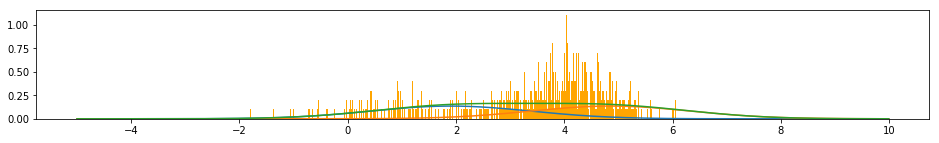

prob = 0.5000, mean_1 = 1.9040, mean_2 = 4.8535, stde_1 = 1.4747, stde_2 = 1.4747
interation 0, log_lik = -1939.97604673171


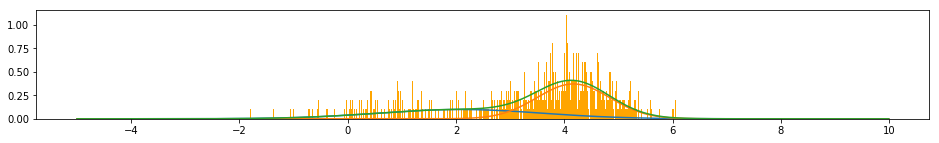

prob = 0.6244, mean_1 = 2.0700, mean_2 = 4.1660, stde_1 = 1.5146, stde_2 = 0.6729
interation 10, log_lik = -1658.6455532363007


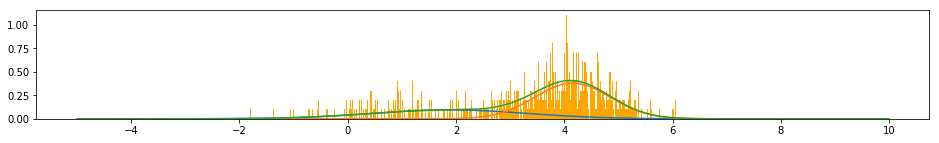

prob = 0.6605, mean_1 = 1.8772, mean_2 = 4.1505, stde_1 = 1.4342, stde_2 = 0.6936
interation 20, log_lik = -1657.1260554608923


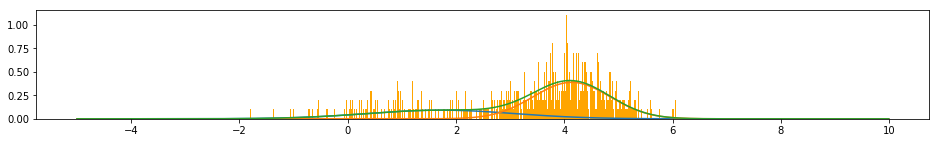

prob = 0.6873, mean_1 = 1.7185, mean_2 = 4.1342, stde_1 = 1.3575, stde_2 = 0.7076
interation 30, log_lik = -1656.1063145750843


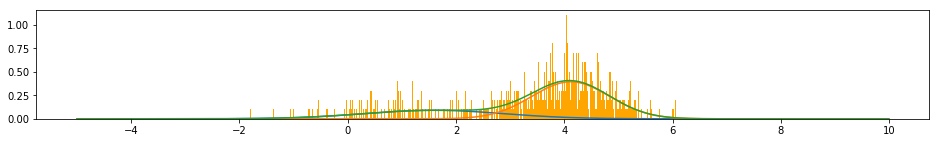

prob = 0.7079, mean_1 = 1.5880, mean_2 = 4.1178, stde_1 = 1.2898, stde_2 = 0.7186
interation 40, log_lik = -1655.3928253840506


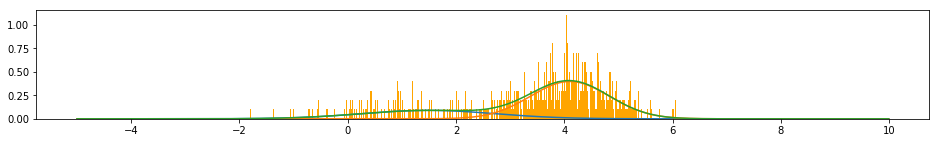

prob = 0.7229, mean_1 = 1.4887, mean_2 = 4.1031, stde_1 = 1.2361, stde_2 = 0.7274
interation 50, log_lik = -1654.9569160864328


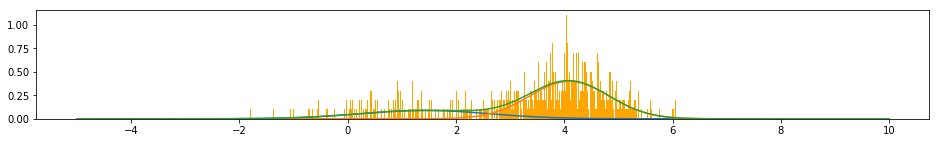

prob = 0.7332, mean_1 = 1.4196, mean_2 = 4.0917, stde_1 = 1.1978, stde_2 = 0.7342
interation 60, log_lik = -1654.7354604752409


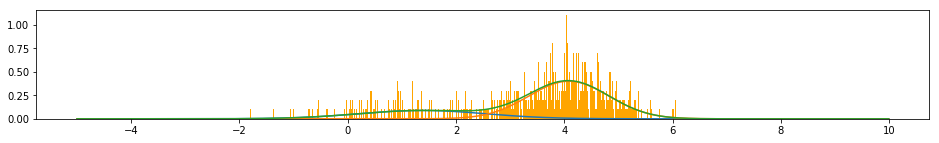

prob = 0.7396, mean_1 = 1.3754, mean_2 = 4.0840, stde_1 = 1.1730, stde_2 = 0.7388
interation 70, log_lik = -1654.6408426213088


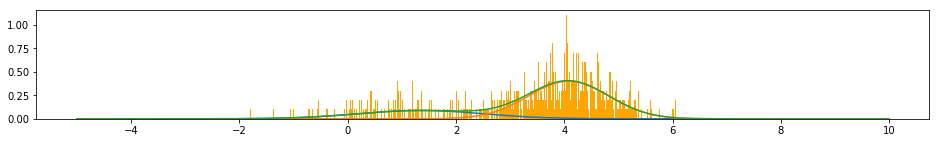

prob = 0.7435, mean_1 = 1.3487, mean_2 = 4.0791, stde_1 = 1.1579, stde_2 = 0.7418
interation 80, log_lik = -1654.6055242514617


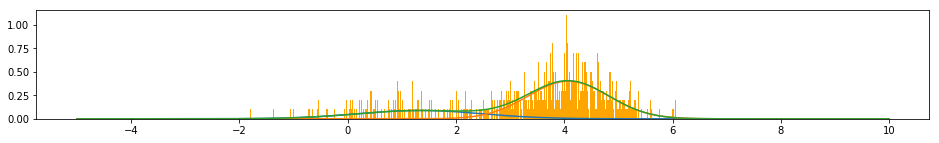

prob = 0.7457, mean_1 = 1.3333, mean_2 = 4.0762, stde_1 = 1.1492, stde_2 = 0.7436
interation 90, log_lik = -1654.5935049436916


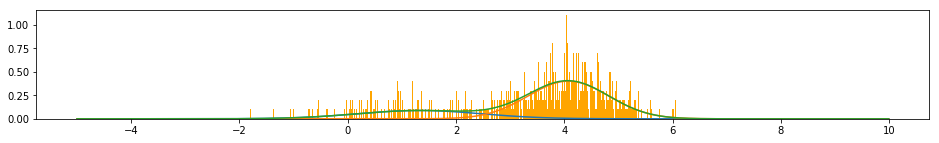

prob = 0.7470, mean_1 = 1.3246, mean_2 = 4.0746, stde_1 = 1.1443, stde_2 = 0.7446
interation 100, log_lik = -1654.5896443692263


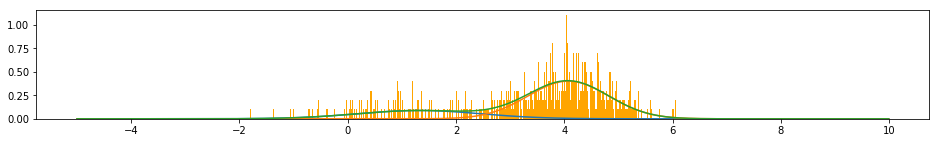

prob = 0.7476, mean_1 = 1.3198, mean_2 = 4.0737, stde_1 = 1.1415, stde_2 = 0.7452
interation 110, log_lik = -1654.588445960173


In [13]:
iterations = 120
plotting = True
for x in range(iterations):
    
    if x%10 == 0 and plotting:
        plot_hist_pdf(prob, mean_1, stde_1, mean_2, stde_2)
        print("interation {}, log_lik = {}".format(x, log_lik))
    
    gamma_i = expectation_step(prob,mean_1,stde_1,mean_2,stde_2)    
    prob, mean_1, stde_1, mean_2, stde_2 = maximisation_step(gamma_i)
    
    prob_list.append(prob)
    mean_1_list.append(mean_1)
    stde_1_list.append(stde_1)
    mean_2_list.append(mean_2)
    stde_2_list.append(stde_2)
    log_lik = calc_log_lik(prob, mean_1, mean_2, stde_1, stde_2)
    log_lik_list.append(log_lik)

### Tracking the convergence of `log_lik`

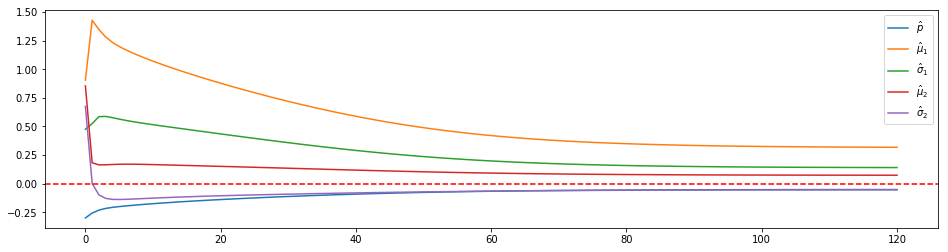

In [14]:
plt.figure(figsize=(16,4))
plt.plot(np.add(prob_list,-PROB_TRUE), label="$\hat{p}$")
plt.plot(np.add(mean_1_list,-MEAN_1_TRUE), label="$\hat{\mu}_1$")
plt.plot(np.add(stde_1_list,-STDE_1_TRUE), label="$\hat{\sigma}_1$")
plt.plot(np.add(mean_2_list,-MEAN_2_TRUE), label="$\hat{\mu}_2$")
plt.plot(np.add(stde_2_list,-STDE_2_TRUE), label="$\hat{\sigma}_2$")
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc="best")
plt.show()

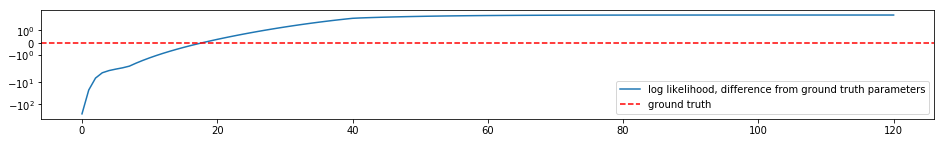

In [15]:
plt.figure(figsize=(16,2))
plt.plot(log_lik_list-LOG_LIK_TRUE, label="log likelihood, difference from ground truth parameters")
plt.yscale('symlog')  # linear when near zero
plt.axhline(y=0, color='r', linestyle='--', label="ground truth")

# plt.plot(log_lik_list, label="log likelihood")
# plt.axhline(y=LOG_LIK_TRUE, color='r', linestyle='--', label="ground truth")

plt.legend(loc="best")
plt.show()

The case presented here is a mixture of 2 Gaussians. However, this can be generalized to a mixture of m Gaussians, where the value of z (the latent variable) can take m different values with probabilitites $p_k$ each and the sum of all $p_k$'s is 1.

Let $p_m$ be a vector of length m consisting of the proportions of each Gaussian in the mixture model, $\mu_m$ be a vector of length m consisting of the means of each Gaussian, and $\sigma_m$ e a vector of length m consisting of the variance of each Gaussian.


$$\gamma_i(\theta_n) =\gamma_{i,n} = E\left(z_i  \mid  \theta_n, \mathbf{X}\right) = P\left(z_i = 1  \mid  \theta_n, \mathbf{X}\right) $$

$$ \gamma_{i,n} = \frac{p_n \phi_{2,n} ( x_i )}{(1 - p_n) \phi_{1,n} ( x_i ) + p_n \phi_{2,n} ( x_i )} $$


$$\begin{align}
p_{m,n+1}&= \frac{
\sum_{i=1}^N \gamma_{i,n}
}{
N
} \\
\mu_{1,n+1} &= \frac{
\sum_{i=1}^N (1 - \gamma_{i,n}) x_i
}{
\sum_{i=1}^N (1 - \gamma_{i,n})
} \\
\sigma_{1, n+1} &= \frac{
\sum_{i=1}^N (1 - \gamma_{i,n}) (x_i - \mu_{2,n})^2
}{
\sum_{i=1}^N (1 - \gamma_{i,n})
} 
\end{align}$$


### References
Pattern Theory 

http://cs229.stanford.edu/notes/cs229-notes8.pdf <BR>
https://www2.isye.gatech.edu/~jeffwu/isye8813/EM_algorithm.pdf <BR>
a bit denser: http://melodi.ee.washington.edu/people/bilmes/mypapers/em.pdf <BR>
https://students.brown.edu/seeing-theory/#firstPage

In [ ]:
# add comments on the references